In [5]:
import sys, os
import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds


from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import newmodel
import CFRM
import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import importlib 

importlib.reload(newmodel)
importlib.reload(utils)
importlib.reload(coupleNMF)

<module 'coupleNMF' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/coupleNMF.py'>

# Simulated

In [7]:
# read in the data
dir = '../data/simulated/2b3c_ziqi1/'
counts_rna = pd.read_csv(os.path.join(dir, 'GxC1.txt'), sep = "\t", header = None).values.T
counts_atac = pd.read_csv(os.path.join(dir, 'RxC2.txt'), sep = "\t", header = None).values.T
A = pd.read_csv(os.path.join(dir, 'region2gene.txt'), sep = "\t", header = None).values.T

counts_rna = np.array(counts_rna)
counts_atac = np.array(counts_atac)
A = np.array(A)

label_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), index_col=0, sep ="\t")["pop"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

counts_rna = counts_rna[np.where(label_rna != 3)[0], :]

run: 0

Epoch 1000, Validating Loss: -132.7230
	 loss 1: 23.10951
	 loss 2: 43.32410
	 loss 3: -99.93697
	 loss 4: -99.21962
	 loss 5: 0.00000
Epoch 2000, Validating Loss: -138.8862
	 loss 1: 22.80025
	 loss 2: 37.78717
	 loss 3: -99.99969
	 loss 4: -99.47398
	 loss 5: 0.00000
Epoch 3000, Validating Loss: -139.7329
	 loss 1: 21.76270
	 loss 2: 37.76843
	 loss 3: -99.99925
	 loss 4: -99.26482
	 loss 5: 0.00000
Epoch 4000, Validating Loss: -140.1075
	 loss 1: 21.48306
	 loss 2: 37.69794
	 loss 3: -99.99966
	 loss 4: -99.28889
	 loss 5: 0.00000
Epoch 5000, Validating Loss: -140.6680
	 loss 1: 21.42823
	 loss 2: 37.27856
	 loss 3: -99.99947
	 loss 4: -99.37531
	 loss 5: 0.00000
Epoch 6000, Validating Loss: -141.1048
	 loss 1: 21.41146
	 loss 2: 36.89747
	 loss 3: -99.99997
	 loss 4: -99.41377
	 loss 5: 0.00000
Epoch 7000, Validating Loss: -141.2508
	 loss 1: 21.41439
	 loss 2: 36.78245
	 loss 3: -99.99991
	 loss 4: -99.44770
	 loss 5: 0.00000
Epoch 8000, Validating Loss: -141.3219
	 loss 1

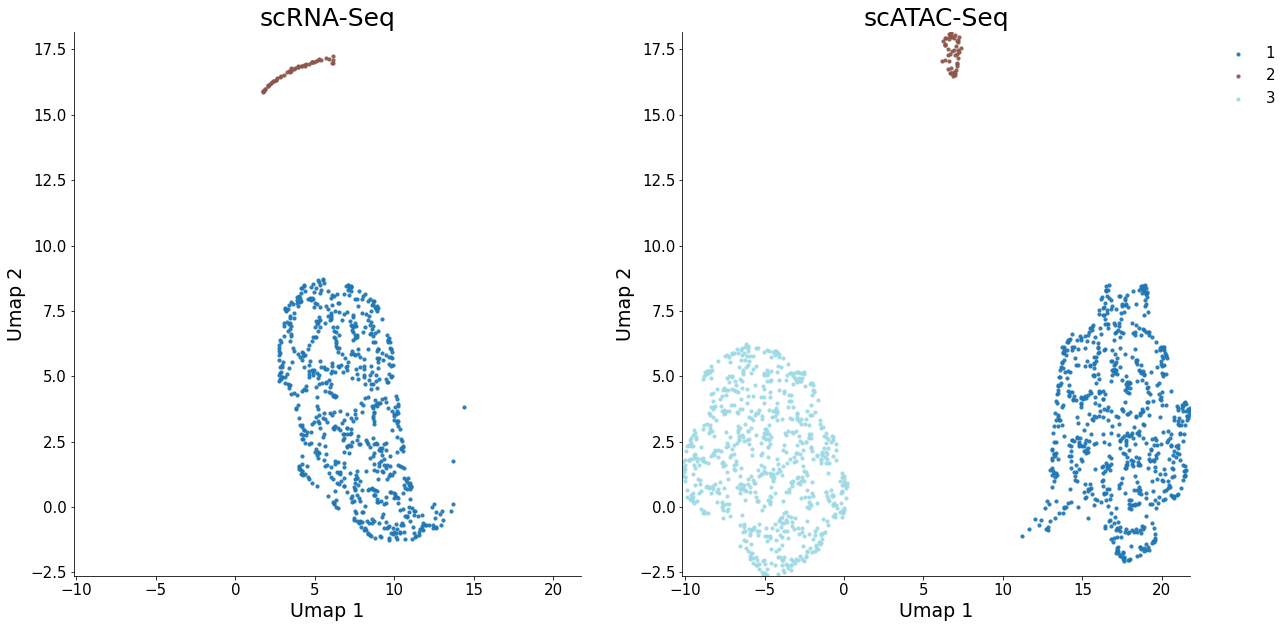

In [54]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

# model1 = model.cfrm_nmfinit(counts, N = 5, batch_size = 0.5, lr = 1e-3, seed = 0).to(device)
# C_1, C_2, A_g, A_r, C_g, C_r = model1.train_func(T = 500, match = True)
# init_val = [C_1, C_2, A_g, A_r, C_g, C_r]
init_val = None
for seed in range(1): 
    print("run: " + str(seed))
    print()
    model1 = newmodel.cfrm_diff(counts, N1 = 2, N2 = 3, K = 2, batch_size = 0.3, interval = 1000, lr = 1e-3, 
                             alpha = [1000, 1000, 100, 100.0, 0],seed = seed, init = init_val, learn_gact = False).to(device)

    model1.train_func(T = 10000)
    
    with torch.no_grad():
        loss, loss1, loss2, loss3, loss4, loss5 = model1.batch_loss('valid')
        print('Final Loss is {:.5f}'.format((loss1 + loss2 + loss3 + loss4).item()))
        
    pca_op = PCA(n_components = 2)
    umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

    # print("diff: " + str(torch.sum(torch.abs(model1.A * model1.B - model1.A)).item()))

    z_rna = model1.softmax(model1.C_1.cpu().detach()).numpy()
    z_rna = model1.softmax(torch.cat((model1.C_1.cpu().detach(),torch.zeros((model1.C_1.shape[0],1))), dim = 1)).numpy()
    # z_rna = np.concatenate((z_rna, np.zeros((z_rna.shape[0],1))), axis = 1)
    z_atac = model1.softmax(model1.C_2.cpu().detach()).numpy()

    max_rna = np.argmax(z_rna, axis = 1)
    max_atac = np.argmax(z_atac, axis = 1)
    z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna = z[:z_rna.shape[0],:]
    z_atac = z[z_rna.shape[0]:,:]

    label_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), index_col=0, sep ="\t")["pop"].values.squeeze()
    label_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

    utils.plot_latent(z_rna, z_atac, label_rna[np.where(label_rna != 3)[0]], label_atac, mode= "separate", save = None, axis_label = "Umap")



In [55]:
def _pairwise_distances(x, y = None):
    x_norm = (x**2).sum(1).view(-1, 1)
    # calculate the pairwise distance between two datasets
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    if y is None:
        dist = dist - torch.diag(dist.diag)

    return torch.clamp(dist, 0.0, np.inf)

def match_alignment(z_rna, z_atac, k = 10):
    # note that the distance is squared version
    dist = _pairwise_distances(z_atac, z_rna).numpy()
    knn_index = np.argpartition(dist, kth = k - 1, axis = 1)[:,(k-1)]
    kth_dist = np.take_along_axis(dist, knn_index[:,None], axis = 1)
    
    K = dist/(kth_dist + 1e-6) 
    K = (dist <= kth_dist) * np.exp(-K) 
    K = K/np.sum(K, axis = 1)[:,None]

    z_atac = torch.FloatTensor(K).mm(z_rna)
    return z_rna, z_atac

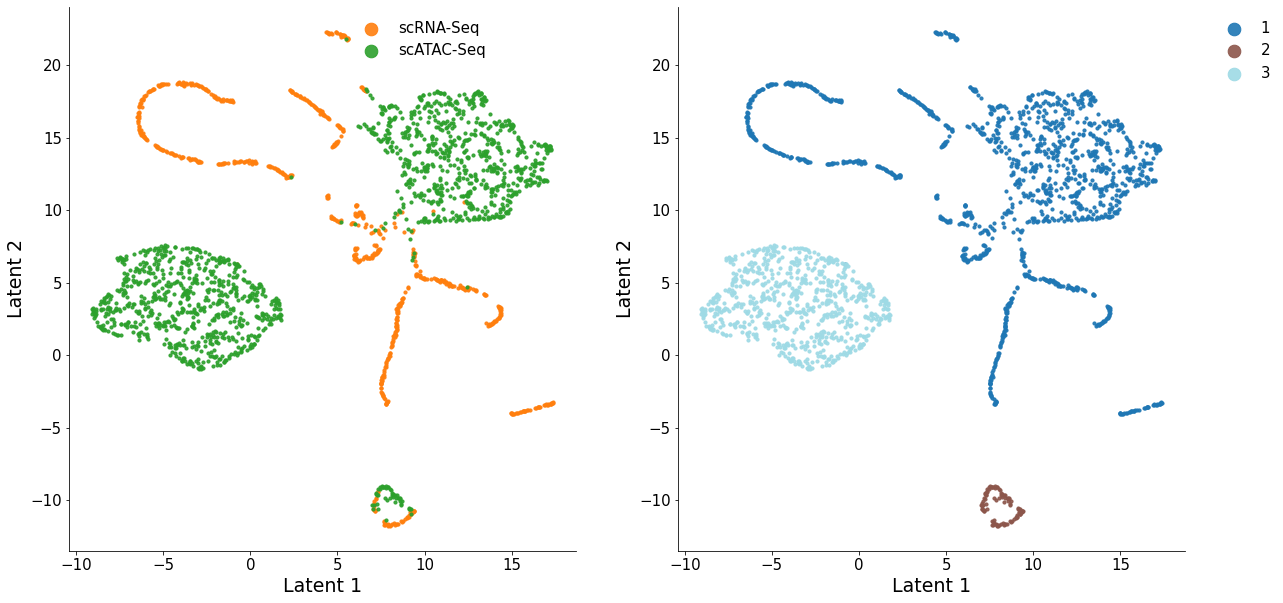

In [59]:
z_rna = model1.softmax(torch.cat((model1.C_1.cpu().detach(),torch.zeros((model1.C_1.shape[0],1))), dim = 1))
# z_rna = np.concatenate((z_rna, np.zeros((z_rna.shape[0],1))), axis = 1)
z_atac = model1.softmax(model1.C_2.cpu().detach())

z_atac, z_rna = match_alignment(z_atac, z_rna, k = 10)



z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

utils.plot_latent(z_rna, z_atac, label_rna[np.where(label_rna != 3)[0]], label_atac, mode= "hybrid", save = None)

In [12]:
# coupleNMF
import warnings
warnings.filterwarnings("ignore")

cnmf = coupleNMF.coupleNMF({"rna":[counts_rna.T], "atac": [counts_atac.T], "gact": [A]}, 
                           N = 5, lambda1 = None, lambda2 = None)

E_symbol = np.array([str(x) for x in range(counts_rna.shape[0])])
P_symbol = np.array([str(x) for x in range(counts_atac.shape[0])])

H1, H2 = cnmf.train_func(E_symbol = E_symbol, P_symbol = P_symbol)


pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = H2.T
z_atac = H1.T

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), index_col=0, sep ="\t")["pop"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None, axis_label = "Umap")

# Training

run: 0

Epoch 10000, Validating Loss: -164.1882
	 loss 1: 23.34296
	 loss 2: 11.79655
	 loss 3: -99.99986
	 loss 4: -99.32789
Final Loss is -164.18823
run: 1

Epoch 10000, Validating Loss: -164.1015
	 loss 1: 23.37945
	 loss 2: 11.82728
	 loss 3: -99.99967
	 loss 4: -99.30856
Final Loss is -164.10150


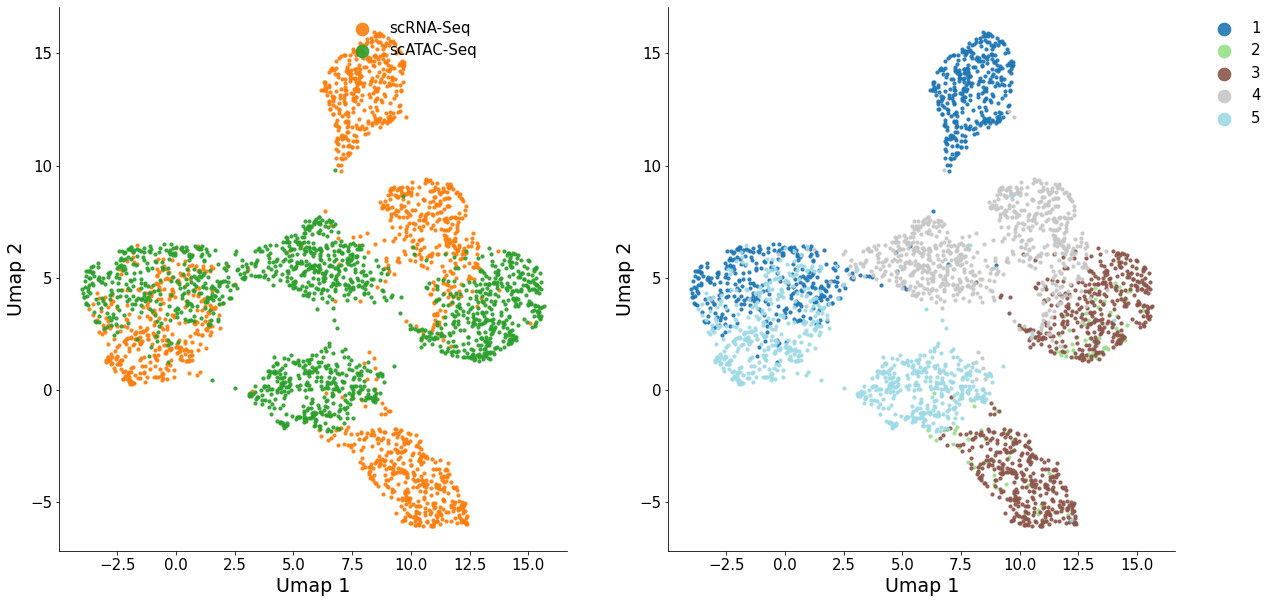

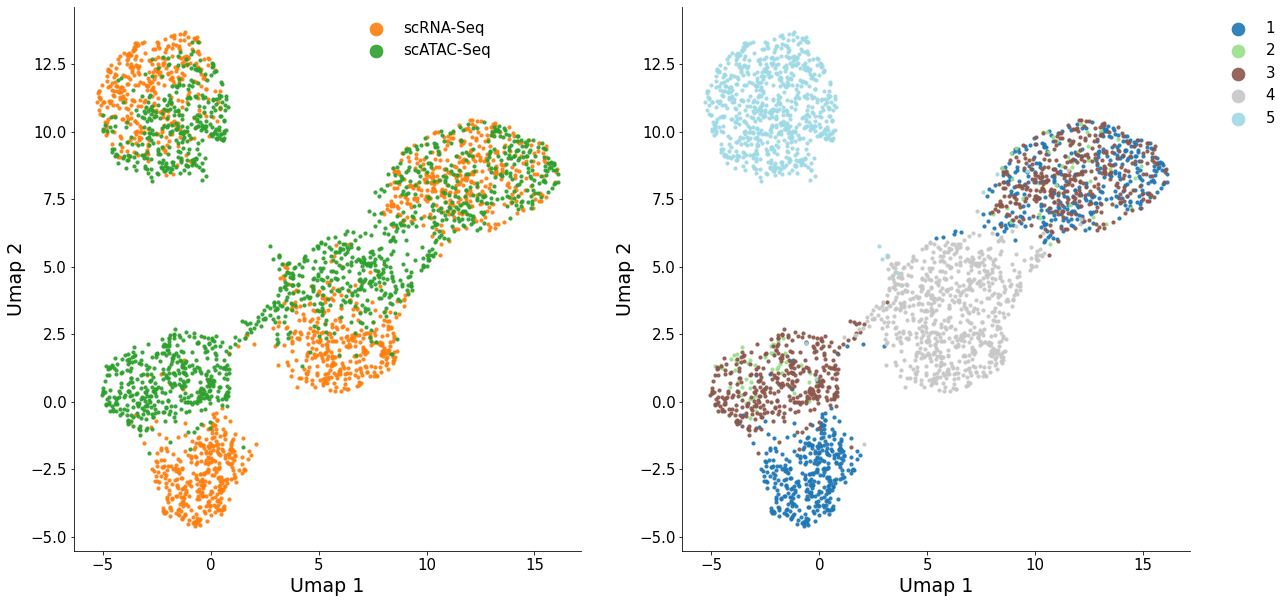

In [9]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

# model1 = model.cfrm_nmfinit(counts, N = 5, batch_size = 0.5, lr = 1e-3, seed = 0).to(device)
# C_1, C_2, A_g, A_r, C_g, C_r = model1.train_func(T = 500, match = True)
# init_val = [C_1, C_2, A_g, A_r, C_g, C_r]
init_val = None
for seed in range(2): 
    print("run: " + str(seed))
    print()
    model1 = model.cfrm_new(counts, N = 5, batch_size = 0.3, interval = 10000, lr = 1e-3, alpha = [1000, 1000, 100, 100.0, 10],seed = seed, init = init_val).to(device)

    model1.train_func(T = 10000)
    
    with torch.no_grad():
        loss, loss1, loss2, loss3, loss4 = model1.batch_loss('valid')
        print('Final Loss is {:.5f}'.format((loss1 + loss2 + loss3 + loss4).item()))
        
    pca_op = PCA(n_components = 2)
    umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

    # print("diff: " + str(torch.sum(torch.abs(model1.A * model1.B - model1.A)).item()))

    z_rna = model1.softmax(model1.C_1.cpu().detach()).numpy()
    z_atac = model1.softmax(model1.C_2.cpu().detach()).numpy()

    max_rna = np.argmax(z_rna, axis = 1)
    max_atac = np.argmax(z_atac, axis = 1)
    z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna = z[:z_rna.shape[0],:]
    z_atac = z[z_rna.shape[0]:,:]

    label_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), index_col=0, sep ="\t")["pop"].values.squeeze()
    label_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

    utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None, axis_label = "Umap")



In [56]:
# kl divergence between uniform latent embeddings 
print(utils.kl_div(model1.softmax(model1.C_1)))
print(utils.kl_div(model1.softmax(model1.C_2)))

tensor(0.6534, device='cuda:0', grad_fn=<MedianBackward0>)
tensor(0.6931, device='cuda:0', grad_fn=<MedianBackward0>)


In [25]:
# model_classic = model.classicCFRM(counts, N = 5, init = "svd")
# from scipy.sparse import csr_matrix, linalg
# def svd_fast(X, n_pcs = 2):
#     U, Sigma, Vh = linalg.svds(X, return_singular_vectors = "u", k = n_pcs, which = "LM")
#     return U

# z_rna = svd_fast(model_classic.G.detach().numpy())
# z_atac = svd_fast(model_classic.R.detach().numpy())

# utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None, axis_label = "Umap")

0.05623119696974754
0.02053399570286274
0.03549829125404358
0.00019891005649697036


# Real

In [9]:
importlib.reload(newmodel)

<module 'newmodel' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/newmodel.py'>

In [4]:
dir = '../data/real/Xichen/small_ver'

counts_rna = sp.load_npz(os.path.join(dir, 'GxC1_small.npz'))
counts_atac = sp.load_npz(os.path.join(dir, 'RxC2_small.npz')).astype(np.float32)
A = sp.load_npz(os.path.join(dir, 'GxR_small.npz'))
subsample = 1

counts_rna = np.array(counts_rna.todense().T)
counts_atac = np.array(counts_atac.todense().T)
counts_rna = counts_rna[::subsample,:]
counts_atac = counts_atac[::subsample,:]
A = np.array(A.todense())

In [5]:
# dir = '../data/real/Xichen'

# counts_rna = sp.load_npz(os.path.join(dir, 'GxC1.npz'))
# counts_atac = sp.load_npz(os.path.join(dir, 'RxC2.npz')).astype(np.float32)
# A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
# subsample = 1

# counts_rna = np.array(counts_rna.todense().T)
# counts_atac = np.array(counts_atac.todense().T)
# counts_rna = counts_rna[::subsample,:]
# counts_atac = counts_atac[::subsample,:]
# A = np.array(A.todense())

In [94]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}
# nmf init, if latent dim = 10, running time grows exponentially
model1 = model.cfrm_nmfinit(counts, N = 10, batch_size = 0.5, lr = 1e-3, seed = 0).to(device)
C_12, C_22, A_g2, A_r2, C_g2, C_r2 = model1.train_func(T = 500, match = True)
# svd init
model1 = model.cfrm_svdinit(counts, N = 5).to(device)
C_12, C_22, A_g2, A_r2, C_g2, C_r2 = model1.train_func(match = True)

[0.02250833 0.03071068 0.03859914 0.04449246 0.04969287 0.05456221
 0.05879489 0.06245486 0.06583749 0.06913359]


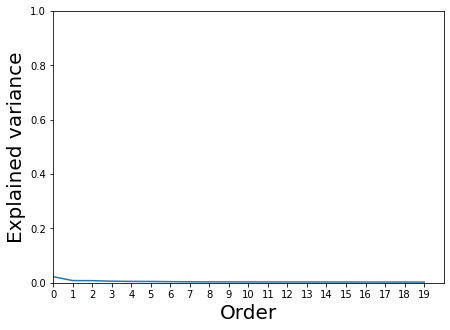

In [38]:
u,s,v = np.linalg.svd(utils.preprocess(counts_rna, mode = "quantile", modality = "RNA"), full_matrices = False)

print(np.cumsum( (s/np.sum(s)) )[:10])

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
ax.plot((s/np.sum(s))[:20])
ax.set_ylim([0,1])
ax.set_xlim([0,20])
_ = ax.set_xticks(np.arange(20))
_ = ax.set_xlabel("Order", fontsize = 20)
_ = ax.set_ylabel("Explained variance", fontsize = 20)

In [7]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}
model1 = model.cfrm_new(counts, N = 15, batch_size = 0.5, interval = 100, lr = 1e-3, alpha = [1000, 1000, 100, 100.0, 100],seed = 0, init = None).to(device)
with torch.no_grad():
    loss, *_ = model1.batch_loss('valid')
    print('Initial Loss is {:.5f}'.format(loss.item()))

model1.train_func(T = 10000)



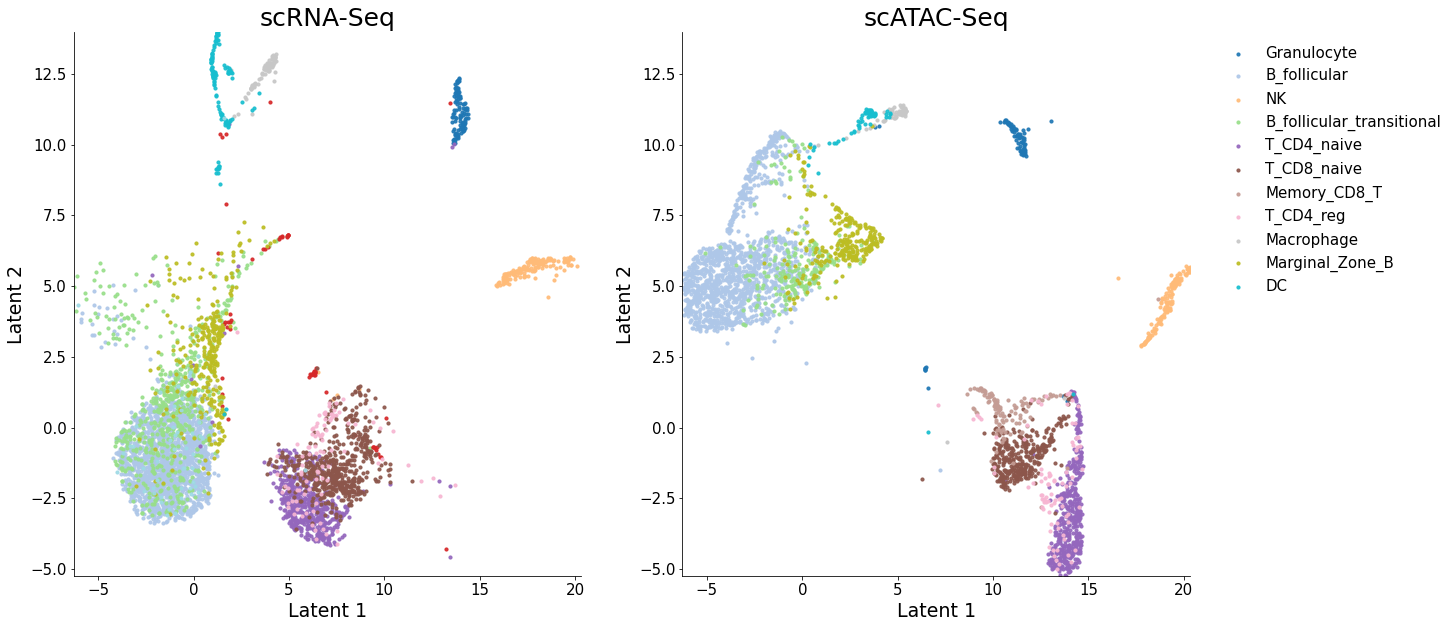

In [96]:
dir = '../data/real/Xichen/'

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach()).numpy()
z_atac = model1.softmax(model1.C_2.cpu().detach()).numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)["cell_type"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)["cell_type"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

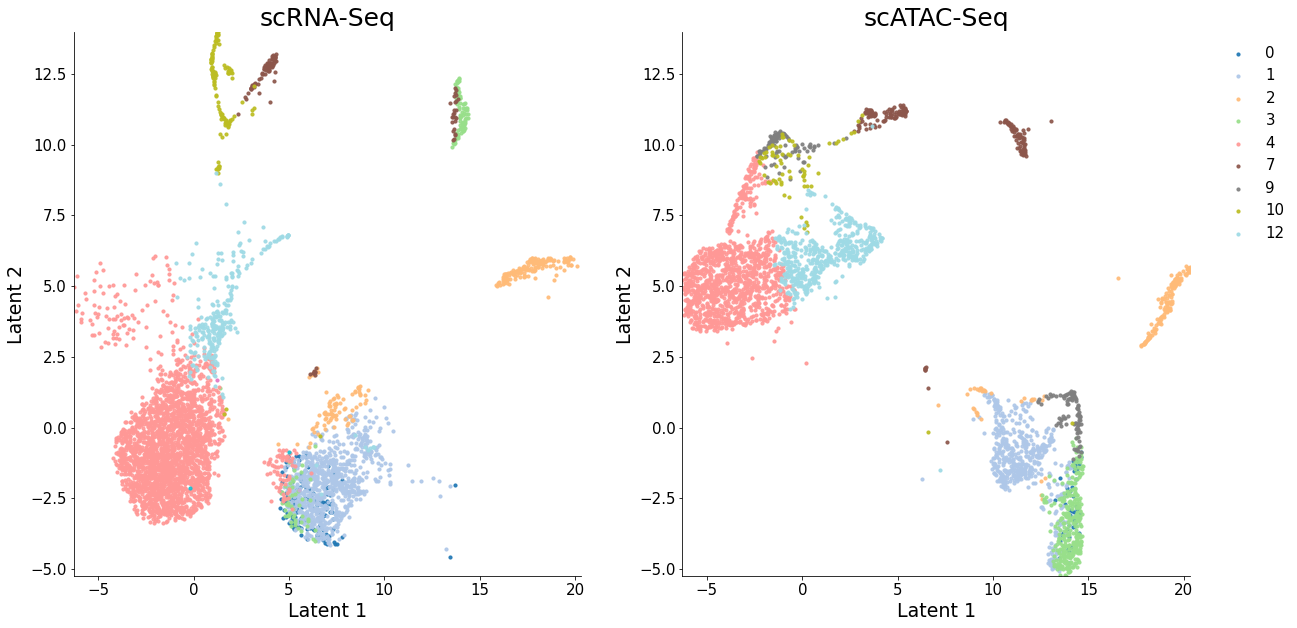

In [98]:
utils.plot_latent(z_rna, z_atac, max_rna, max_atac, mode= "separate", save = None)

In [10]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}
model1 = newmodel.cfrm_new2(counts, N = 15, batch_size = 0.5, interval = 1000, lr = 1e-3, alpha = [1000, 1000, 100, 100.0, 100],seed = 0, init = None).to(device)
with torch.no_grad():
    loss, *_ = model1.batch_loss('valid')
    print('Initial Loss is {:.5f}'.format(loss.item()))

model1.train_func(T = 10000)


Initial Loss is 51.86002
Epoch 1000, Validating Loss: -43.4652
	 loss 1: 7.72573
	 loss 2: 73.53007
	 loss 3: -99.99996
	 loss 4: -98.19617
	 loss 5: 73.47518
Epoch 2000, Validating Loss: -45.9601
	 loss 1: 7.41449
	 loss 2: 72.15866
	 loss 3: -99.99983
	 loss 4: -98.12092
	 loss 5: 72.58750
Epoch 3000, Validating Loss: -47.6185
	 loss 1: 7.22148
	 loss 2: 71.72979
	 loss 3: -99.99979
	 loss 4: -98.14856
	 loss 5: 71.57854
Epoch 4000, Validating Loss: -49.8642
	 loss 1: 7.14281
	 loss 2: 71.60545
	 loss 3: -99.99973
	 loss 4: -98.22075
	 loss 5: 69.60801
Epoch 5000, Validating Loss: -51.6711
	 loss 1: 7.08347
	 loss 2: 71.52215
	 loss 3: -99.99955
	 loss 4: -98.37188
	 loss 5: 68.09469
Epoch 6000, Validating Loss: -52.6550
	 loss 1: 7.03239
	 loss 2: 71.46799
	 loss 3: -99.99934
	 loss 4: -98.52184
	 loss 5: 67.36582
Epoch 7000, Validating Loss: -53.1489
	 loss 1: 6.99364
	 loss 2: 71.43192
	 loss 3: -99.99920
	 loss 4: -98.63593
	 loss 5: 67.06068
Epoch 8000, Validating Loss: -53.0264

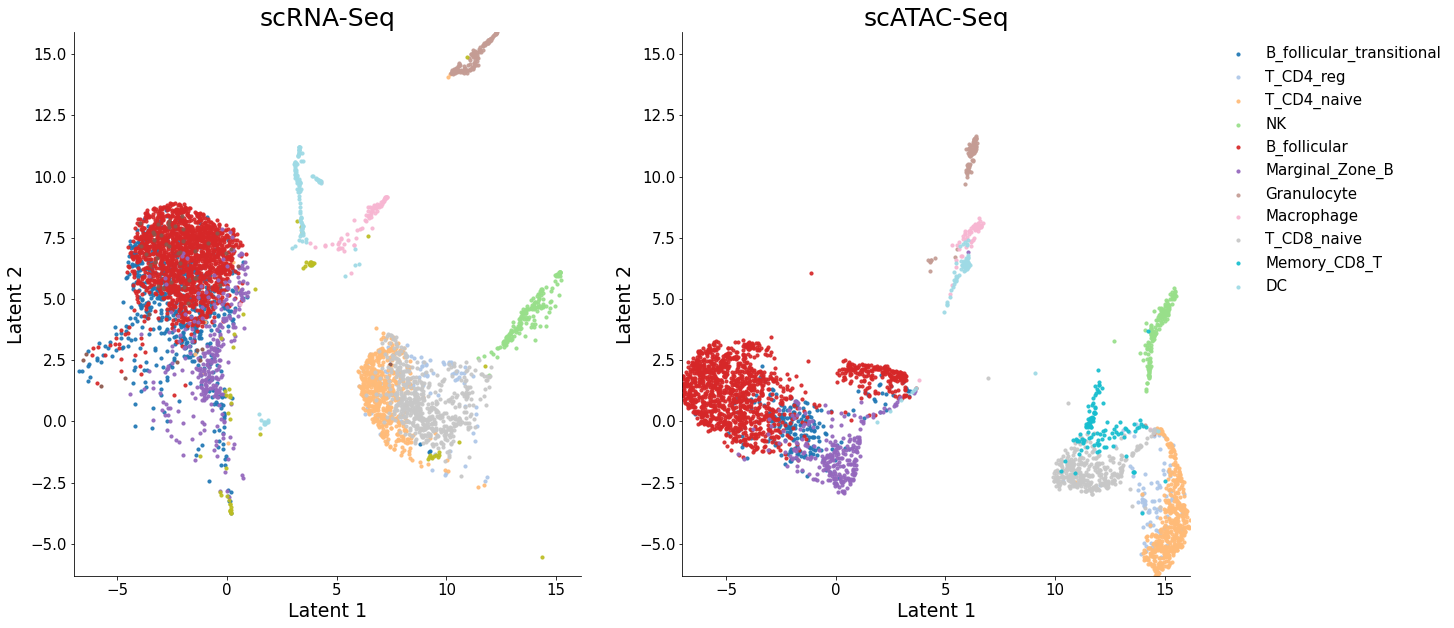

In [11]:
dir = '../data/real/Xichen/'

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach()).numpy()
z_atac = model1.softmax(model1.C_2.cpu().detach()).numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)["cell_type"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)["cell_type"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

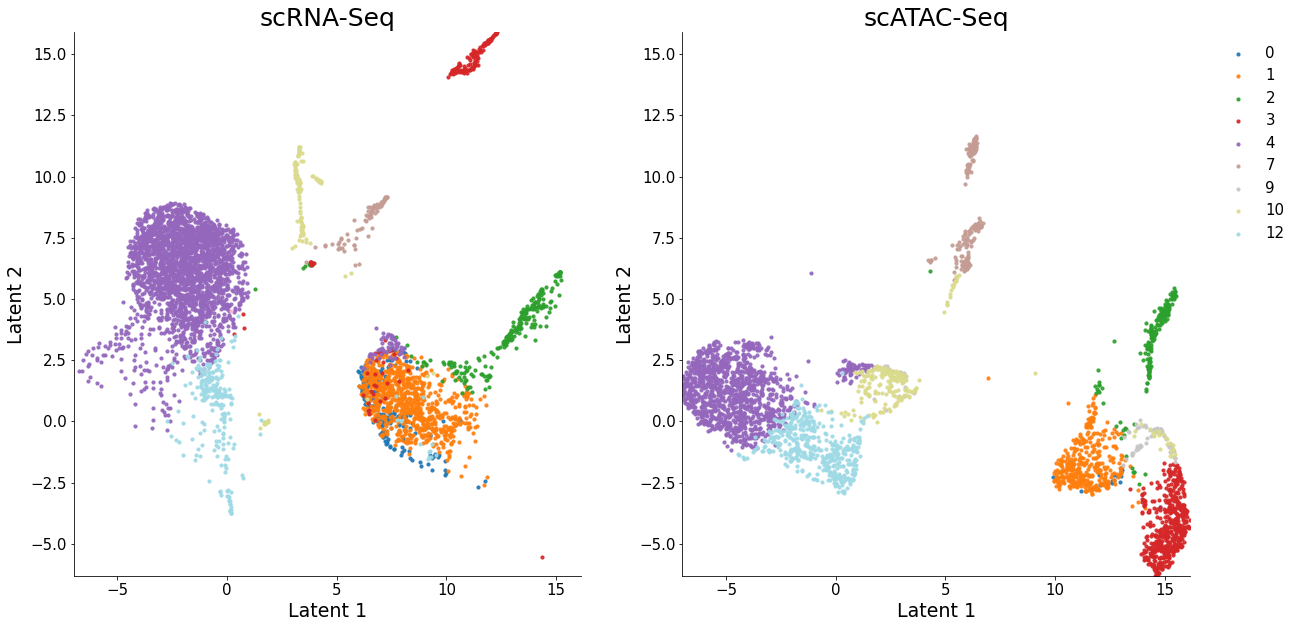

In [12]:
utils.plot_latent(z_rna, z_atac, max_rna, max_atac, mode= "separate", save = None)

In [61]:
model_classic = model.classicCFRM(counts, N = 10, init = "svd")

0.08055009692907333
0.0086861252784729
0.07184699177742004
1.6977135601337068e-05


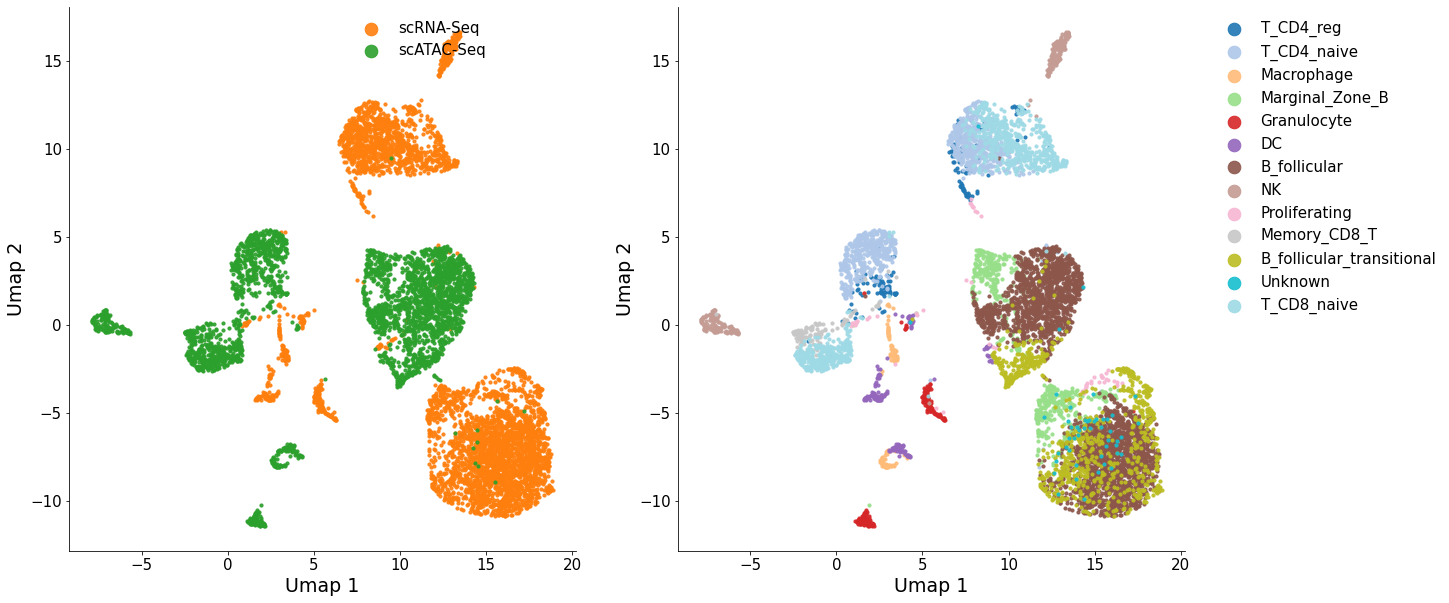

In [62]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model_classic.C_1.cpu().detach().numpy()
z_atac = model_classic.C_2.cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)["cell_type"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)["cell_type"].values.squeeze()[::subsample]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None, axis_label = "Umap")

In [13]:
# read in the real BMMC data

dir = '../data/real/BMMC/small_ver/'
counts_rna = sp.load_npz(os.path.join(dir, 'GxC1.npz'))
counts_atac = sp.load_npz(os.path.join(dir, 'RxC2.npz')).astype(np.float32)
A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
subsample = 1

counts_rna = np.array(counts_rna.todense().T)
counts_atac = np.array(counts_atac.todense().T)
counts_rna = counts_rna[::subsample,:]
counts_atac = counts_atac[::subsample,:]
A = np.array(A.todense())

counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

model1 = newmodel.cfrm_new2(counts, N = 30, batch_size = 0.1, interval=1000, lr=1e-3, 
                           alpha = [1000, 1000, 100, 100, 100], seed = 0).to(device)

# with torch.no_grad():
#     loss, *_ = model1.batch_loss('valid')
#     print('Initial Loss is {:.5f}'.format(loss.item()))

model1.train_func(T = 10000)
# model1.load_state_dict(torch.load('../check_points/real5.pt'))

Epoch 1000, Validating Loss: -87.6438
	 loss 1: 6.60829
	 loss 2: 16.08675
	 loss 3: -99.99999
	 loss 4: -99.48613
	 loss 5: 89.14725
Epoch 2000, Validating Loss: -96.8074
	 loss 1: 6.59672
	 loss 2: 15.99796
	 loss 3: -99.99993
	 loss 4: -98.63503
	 loss 5: 79.23284
Epoch 3000, Validating Loss: -103.7541
	 loss 1: 6.33996
	 loss 2: 15.76808
	 loss 3: -99.99987
	 loss 4: -97.48963
	 loss 5: 71.62740
Epoch 4000, Validating Loss: -108.4325
	 loss 1: 6.16410
	 loss 2: 15.65099
	 loss 3: -99.99988
	 loss 4: -96.45904
	 loss 5: 66.21136
Epoch 5000, Validating Loss: -110.7814
	 loss 1: 5.99581
	 loss 2: 15.60291
	 loss 3: -99.99986
	 loss 4: -95.73674
	 loss 5: 63.35643
Epoch 6000, Validating Loss: -111.7781
	 loss 1: 5.81177
	 loss 2: 15.57746
	 loss 3: -99.99986
	 loss 4: -95.36540
	 loss 5: 62.19789
Epoch 7000, Validating Loss: -112.0179
	 loss 1: 5.72228
	 loss 2: 15.55580
	 loss 3: -99.99992
	 loss 4: -95.23634
	 loss 5: 61.94033
Epoch 8000, Validating Loss: -112.2967
	 loss 1: 5.65451


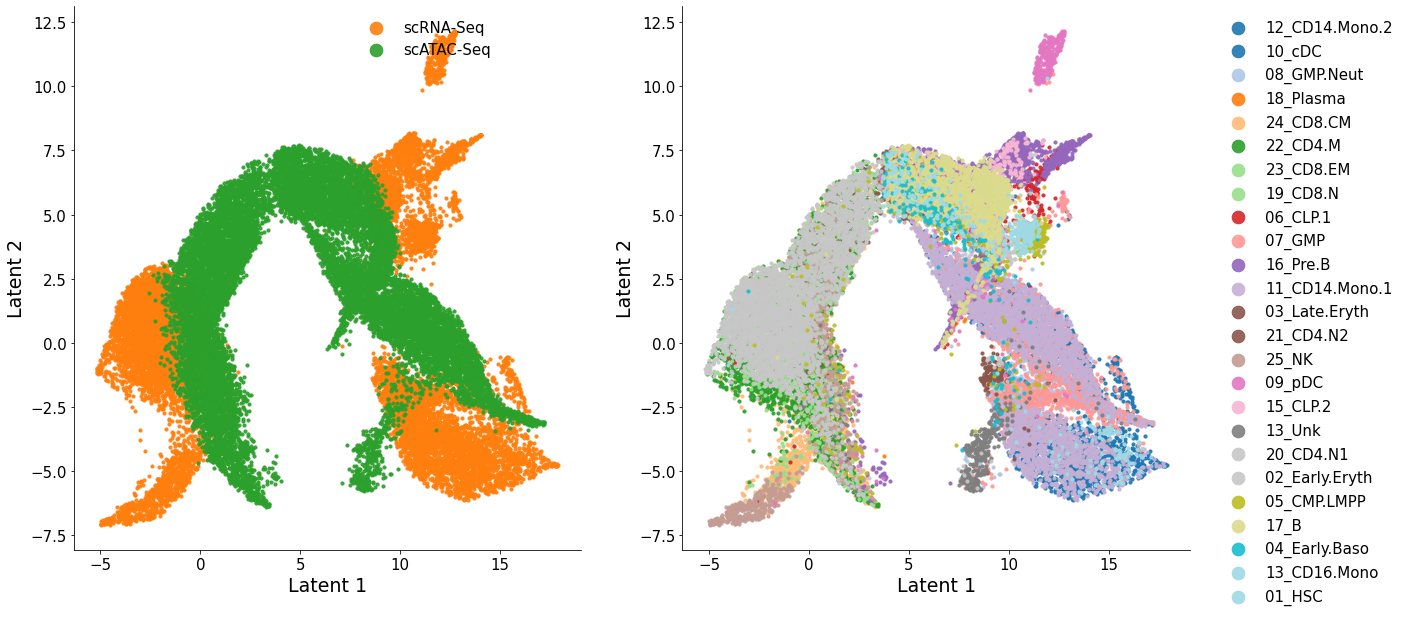

In [14]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach())
z_atac = model1.softmax(model1.C_2.cpu().detach())
max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)

# z_rna, z_atac = utils.match_alignment(z_rna, z_atac, k = 10)
# z_atac, z_rna = utils.match_alignment(z_atac, z_rna, k = 10)


z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_rna.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_atac.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None)


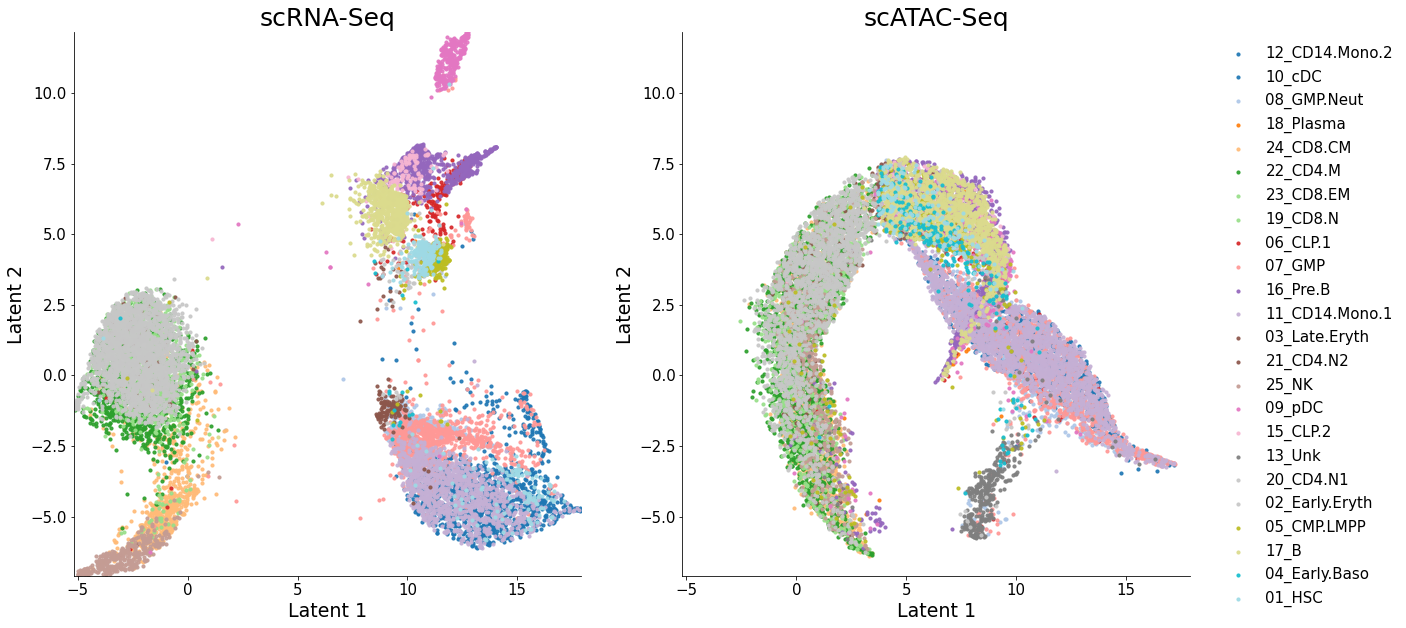

In [15]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

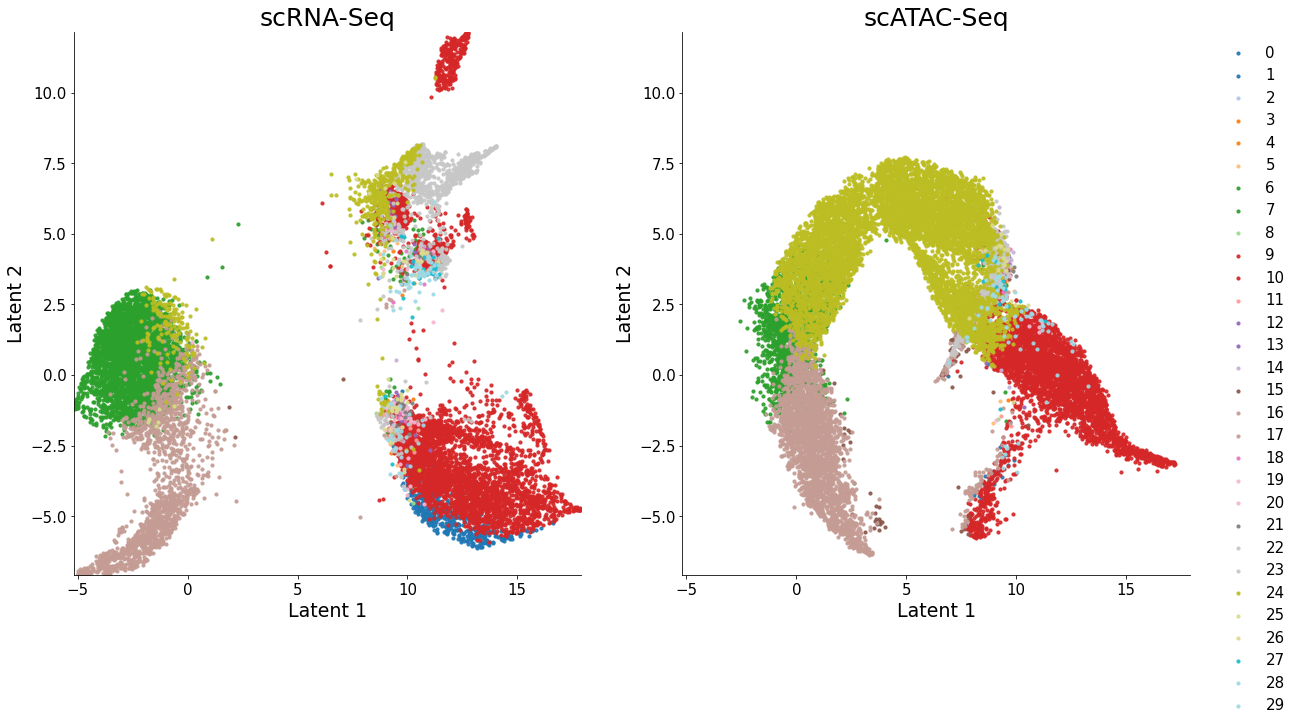

In [16]:
utils.plot_latent(z_rna, z_atac, max_rna, max_atac, mode= "separate", save = None)

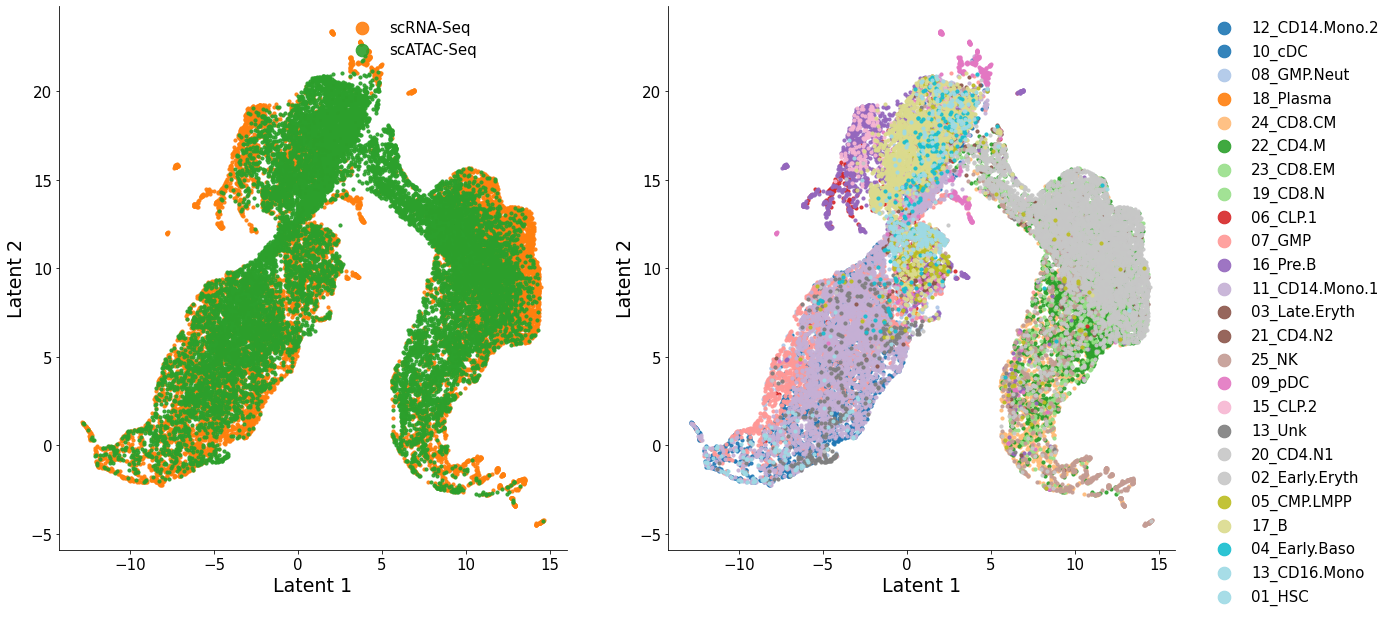

In [17]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach())
z_atac = model1.softmax(model1.C_2.cpu().detach())
max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)

z_rna, z_atac = utils.match_alignment(z_rna, z_atac, k = 10)
z_atac, z_rna = utils.match_alignment(z_atac, z_rna, k = 10)


z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_rna.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_atac.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None)

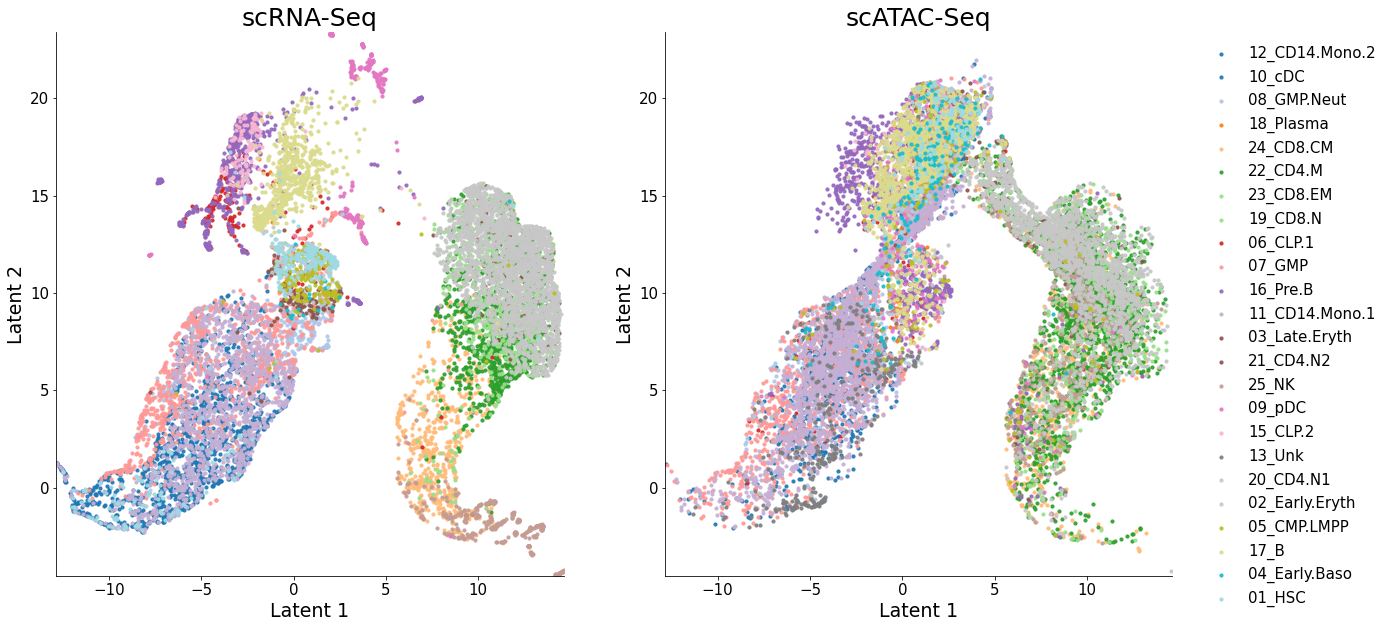

In [18]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [73]:
# read in the real BMMC data

dir = '../data/real/BMMC/small_ver'
counts_rna = sp.load_npz(os.path.join(dir, 'GxC1.npz'))
counts_atac = sp.load_npz(os.path.join(dir, 'RxC2.npz')).astype(np.float32)
A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
subsample = 3

counts_rna = np.array(counts_rna.todense().T)
counts_atac = np.array(counts_atac.todense().T)
counts_rna = counts_rna[::subsample,:]
counts_atac = counts_atac[::subsample,:]
A = np.array(A.todense())

counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

model1 = newmodel.cfrm_new(counts, N = 30, batch_size = 0.3, interval=1000, lr=1e-3, 
                           alpha = [1000, 1000, 100, 100, 100], seed = 0).to(device)

with torch.no_grad():
    loss, *_ = model1.batch_loss('valid')
    print('Initial Loss is {:.5f}'.format(loss.item()))

model1.train_func(T = 10000)
# model1.load_state_dict(torch.load('../check_points/real5.pt'))

Initial Loss is -69.63864
Epoch 1000, Validating Loss: -86.1296
	 loss 1: 7.49856
	 loss 2: 16.00093
	 loss 3: -99.99971
	 loss 4: -99.03326
	 loss 5: 89.40392
Epoch 2000, Validating Loss: -101.5681
	 loss 1: 6.61215
	 loss 2: 15.60347
	 loss 3: -99.99980
	 loss 4: -98.37340
	 loss 5: 74.58952
Epoch 1000, Validating Loss: -119.9433
	 loss 1: 6.04421
	 loss 2: 15.52682
	 loss 3: -99.99982
	 loss 4: -98.30988
	 loss 5: 56.79535
Epoch 2000, Validating Loss: -129.7220
	 loss 1: 5.90687
	 loss 2: 15.50496
	 loss 3: -99.99985
	 loss 4: -98.30522
	 loss 5: 47.17125
Epoch 3000, Validating Loss: -137.9003
	 loss 1: 5.84228
	 loss 2: 15.48668
	 loss 3: -99.99983
	 loss 4: -98.31531
	 loss 5: 39.08583
Epoch 4000, Validating Loss: -144.6915
	 loss 1: 5.79319
	 loss 2: 15.46971
	 loss 3: -99.99978
	 loss 4: -98.39368
	 loss 5: 32.43901
Epoch 5000, Validating Loss: -150.3261
	 loss 1: 5.73900
	 loss 2: 15.45323
	 loss 3: -99.99977
	 loss 4: -98.42180
	 loss 5: 26.90323
Epoch 6000, Validating Loss: -

In [74]:
torch.sum(torch.abs(model1.A * model1.B - model1.A))

tensor(748.8400, device='cuda:0', grad_fn=<SumBackward0>)

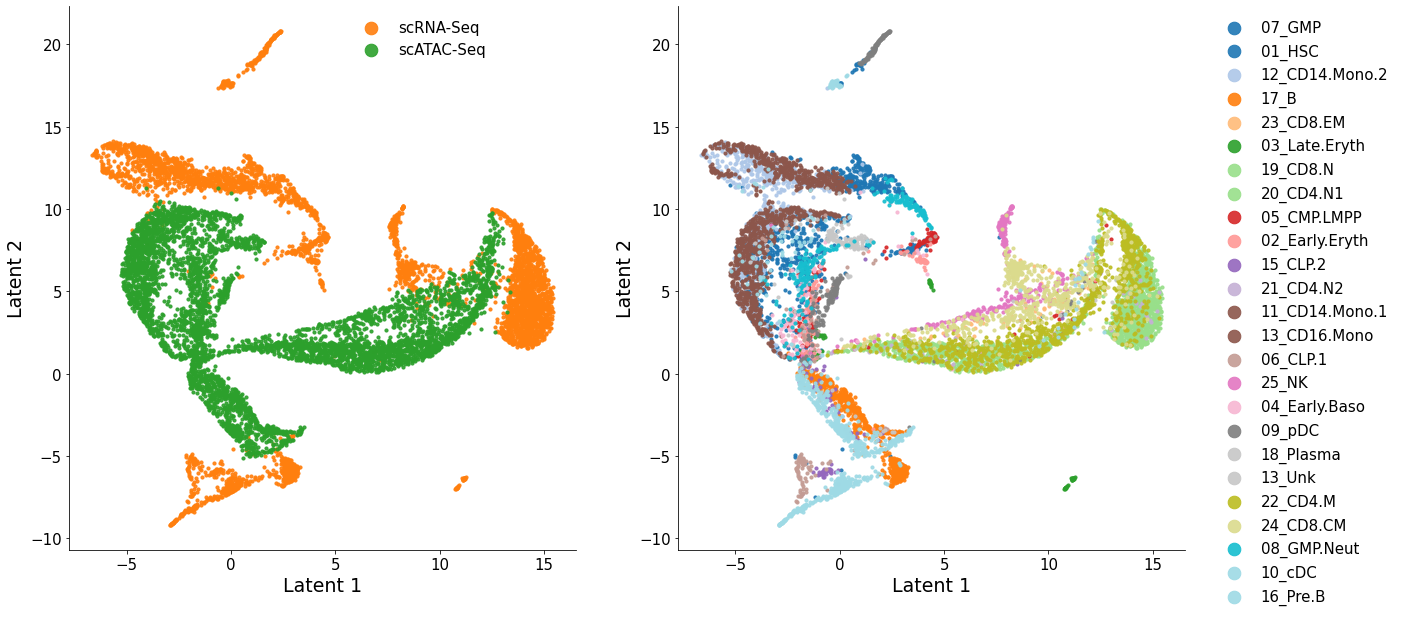

In [75]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach())
z_atac = model1.softmax(model1.C_2.cpu().detach())
max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)

# z_rna, z_atac = utils.match_alignment(z_rna, z_atac, k = 10)
# z_atac, z_rna = utils.match_alignment(z_atac, z_rna, k = 10)


z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_rna.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_atac.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None)



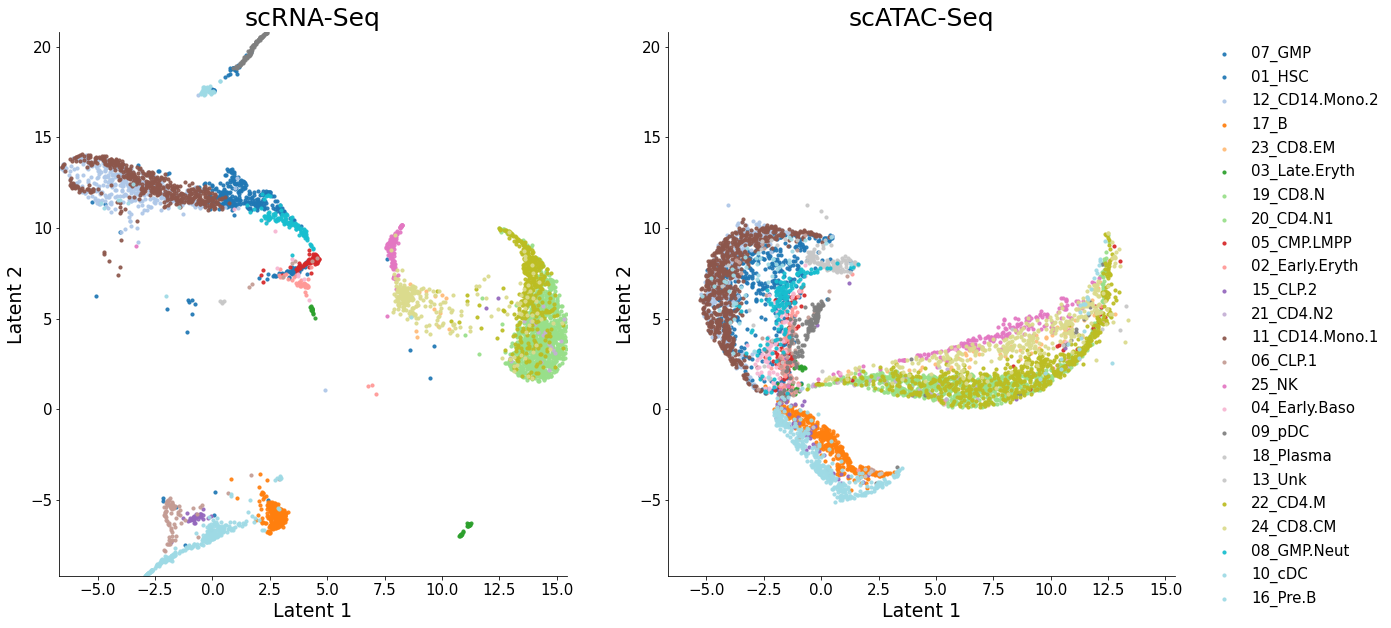

In [76]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)



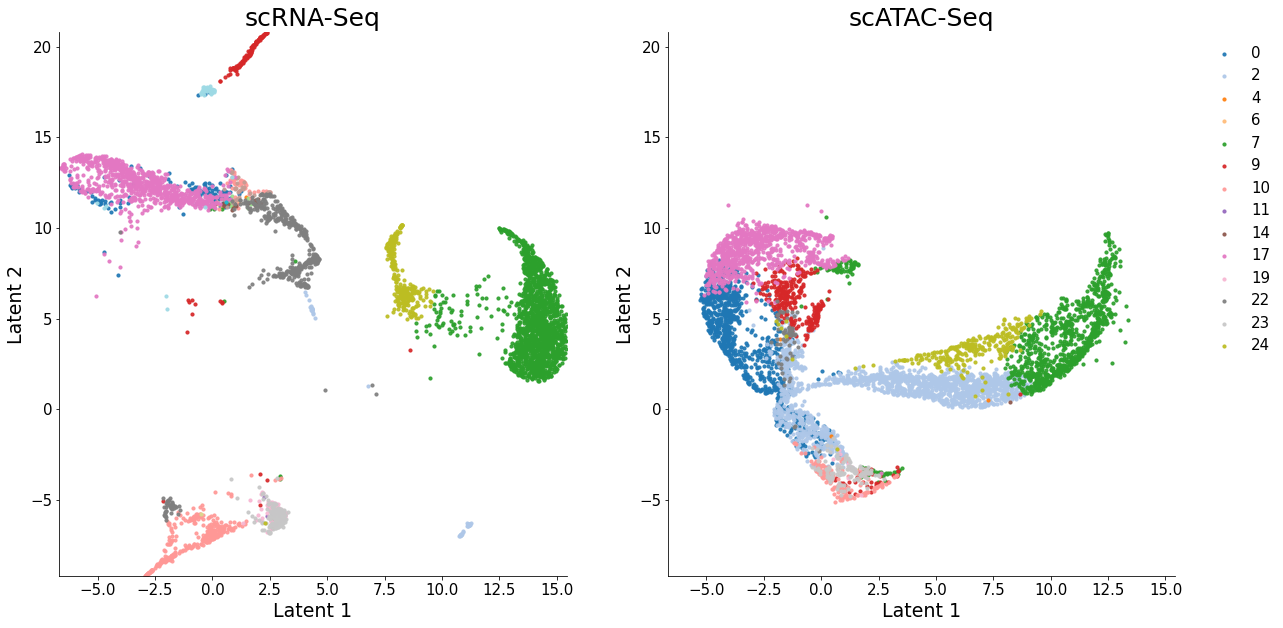

In [77]:
utils.plot_latent(z_rna, z_atac, max_rna, max_atac, mode= "separate", save = None)

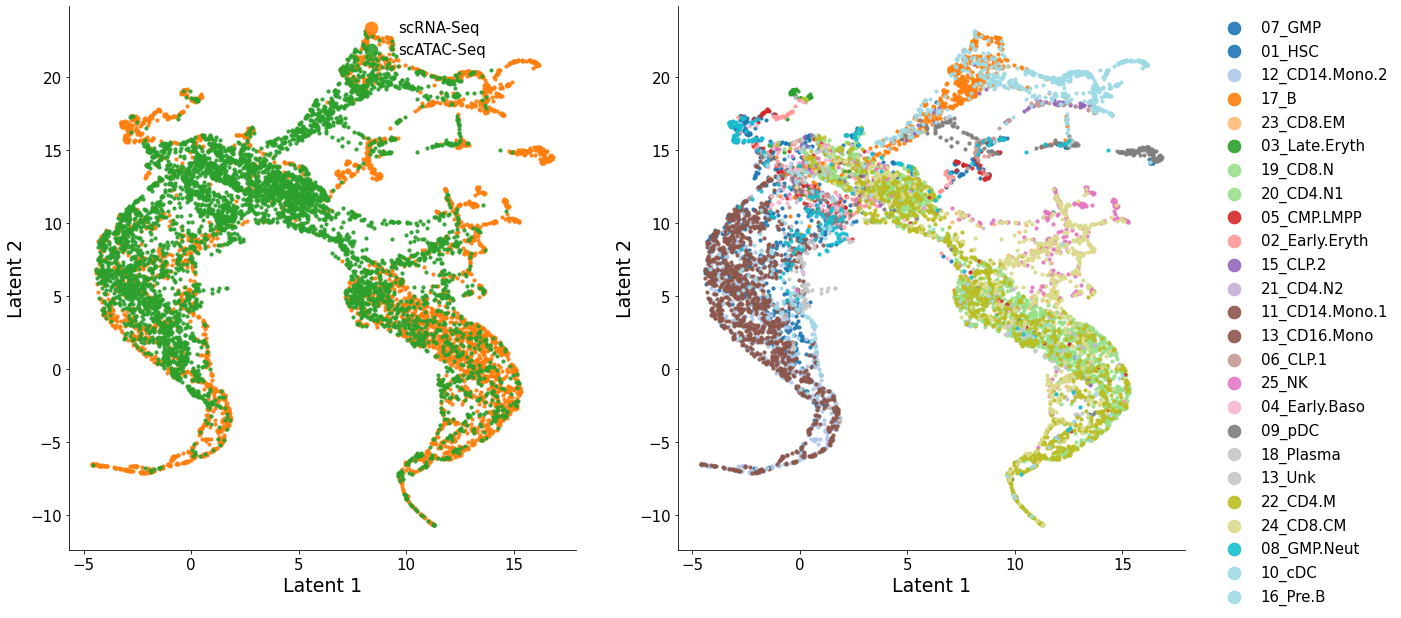

In [78]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach())
z_atac = model1.softmax(model1.C_2.cpu().detach())
max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)

z_rna, z_atac = utils.match_alignment(z_rna, z_atac, k = 10)
z_atac, z_rna = utils.match_alignment(z_atac, z_rna, k = 10)


z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_rna.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_atac.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None)

In [32]:
u,s,v = np.linalg.svd(counts_rna, full_matrices = False)

np.cumsum( (s/np.sum(s)) )

array([0.18725564, 0.34061557, 0.38699907, 0.42554447, 0.4566985 ,
       0.4862886 , 0.50808483, 0.52570784, 0.54073125, 0.55269253,
       0.5608228 , 0.56846607, 0.5755819 , 0.58254206, 0.589324  ,
       0.595506  , 0.60115284, 0.60640943, 0.61130774, 0.61593086,
       0.62014633, 0.62425405, 0.6281264 , 0.6318634 , 0.63540334,
       0.6388819 , 0.6423122 , 0.6456304 , 0.6487924 , 0.65194505,
       0.65504044, 0.6580303 , 0.66090864, 0.66374075, 0.6664621 ,
       0.66914886, 0.6717855 , 0.6743273 , 0.67686117, 0.6793469 ,
       0.68169737, 0.68399006, 0.6861929 , 0.6883528 , 0.6904509 ,
       0.69243443, 0.69439757, 0.69627464, 0.69810295, 0.6999035 ,
       0.70165944, 0.7033796 , 0.7050929 , 0.70679194, 0.7084118 ,
       0.7100187 , 0.7116078 , 0.71314335, 0.71466225, 0.7161588 ,
       0.7176229 , 0.7190731 , 0.72051436, 0.72193956, 0.7233513 ,
       0.72474796, 0.7261172 , 0.7274664 , 0.7288048 , 0.73012394,
       0.73142767, 0.7327199 , 0.7339938 , 0.73525256, 0.73649

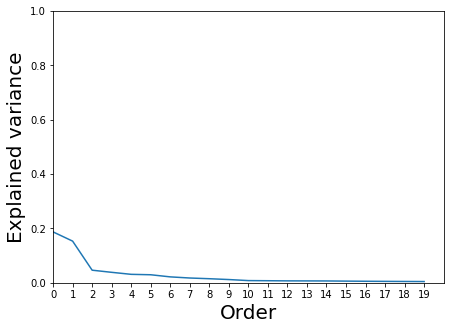

In [33]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
ax.plot((s/np.sum(s))[:20])
ax.set_ylim([0,1])
ax.set_xlim([0,20])
_ = ax.set_xticks(np.arange(20))
_ = ax.set_xlabel("Order", fontsize = 20)
_ = ax.set_ylabel("Explained variance", fontsize = 20)

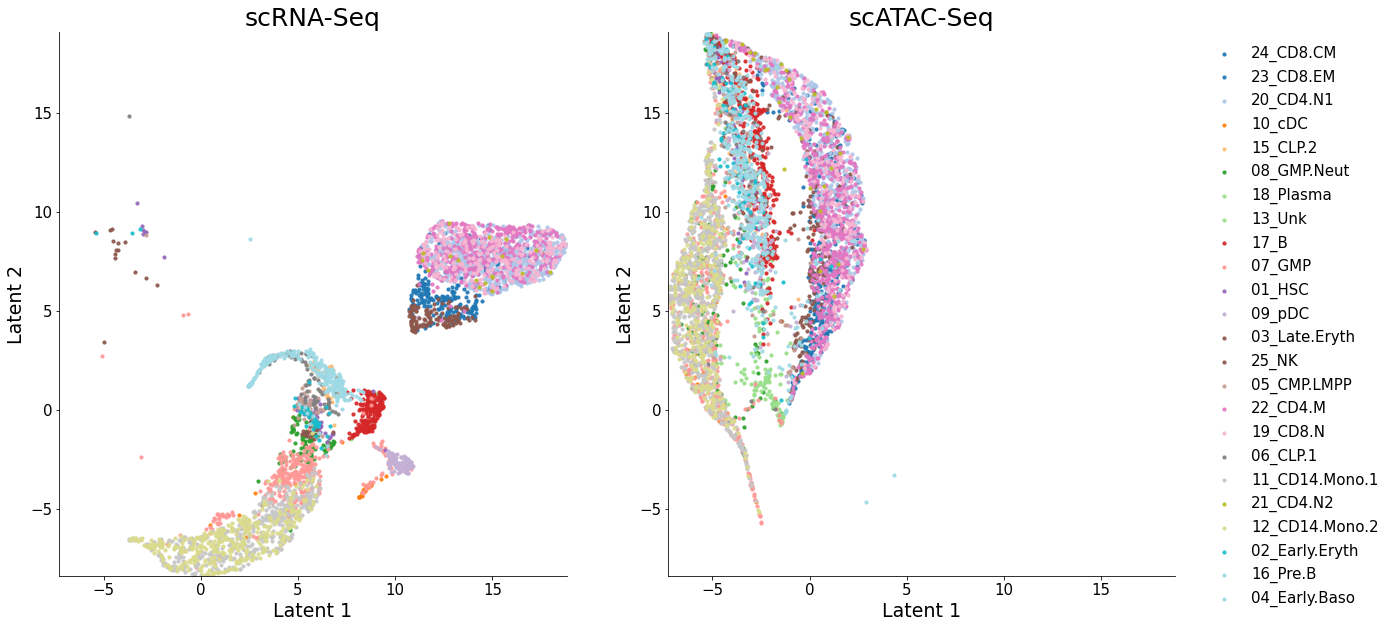

In [39]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model1.softmax(model1.C_1.cpu().detach()).numpy()
z_atac = model1.softmax(model1.C_2.cpu().detach()).numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_rna.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_atac.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [98]:
model_classic = model.classicCFRM(counts, N = 10, init = "svd")

0.02966867946088314
0.011559577658772469
0.01810765452682972
1.4479809351541917e-06


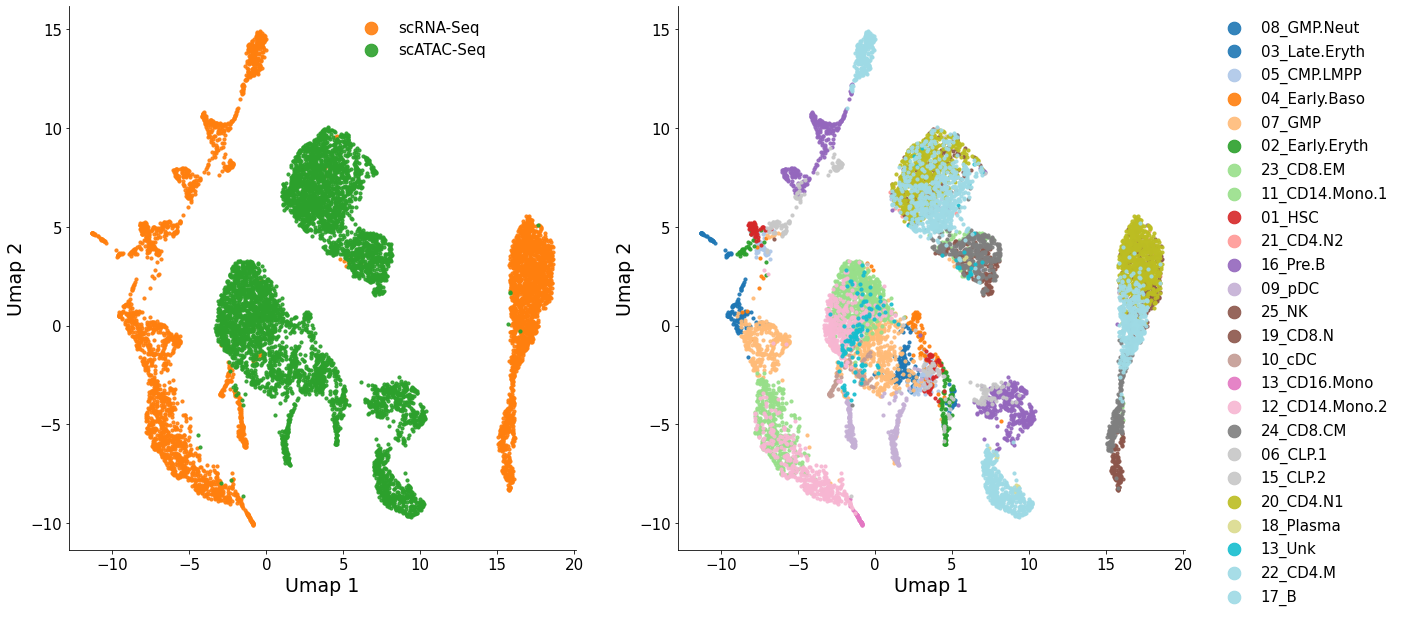

In [100]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

z_rna = model_classic.C_1.cpu().detach().numpy()
z_atac = model_classic.C_2.cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_rna.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join('../data/real/BMMC/', "meta_atac.csv"), index_col=0)["cluster"].values.squeeze()[::subsample]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "hybrid", save = None, axis_label = "Umap")

In [39]:
dir = '../data/real/mmskin/processed/'

counts_rna = sp.load_npz(os.path.join(dir, 'GxC1.npz'))
counts_atac = sp.load_npz(os.path.join(dir, 'RxC2.npz')).astype(np.float32)
A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
subsample = 10

counts_rna = np.array(counts_rna.todense().T)
counts_atac = np.array(counts_atac.todense().T)
counts_rna = counts_rna[::subsample,:]
counts_atac = counts_atac[::subsample,:]
A = np.array(A.todense())

In [71]:
importlib.reload(model)

<module 'model' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/model.py'>

In [72]:
counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}
model1 = model.cfrm_new(counts, N = 15, batch_size = 0.3, interval = 1000, lr = 1e-3, alpha = [1000, 1000, 1, 1, 1],seed = 0, init = None).to(device)
with torch.no_grad():
    loss, *_ = model1.batch_loss('valid')
    print('Initial Loss is {:.5f}'.format(loss.item()))

model1.train_func(T = 10000)



Initial Loss is 12.94204
Epoch 1000, Validating Loss: 10.3495
	 loss 1: 3.80966
	 loss 2: 8.52388
	 loss 3: -0.99884
	 loss 4: -0.98524
Epoch 2000, Validating Loss: 10.0152
	 loss 1: 3.52367
	 loss 2: 8.46398
	 loss 3: -0.99938
	 loss 4: -0.97303
Epoch 3000, Validating Loss: 9.8843
	 loss 1: 3.41996
	 loss 2: 8.43741
	 loss 3: -0.99949
	 loss 4: -0.97358
Epoch 4000, Validating Loss: 9.8054
	 loss 1: 3.36337
	 loss 2: 8.41783
	 loss 3: -0.99969
	 loss 4: -0.97613
Epoch 5000, Validating Loss: 9.7528
	 loss 1: 3.32837
	 loss 2: 8.40140
	 loss 3: -0.99971
	 loss 4: -0.97730
Epoch 6000, Validating Loss: 9.7105
	 loss 1: 3.29995
	 loss 2: 8.38785
	 loss 3: -0.99971
	 loss 4: -0.97759
Epoch 7000, Validating Loss: 9.6756
	 loss 1: 3.27654
	 loss 2: 8.37675
	 loss 3: -0.99973
	 loss 4: -0.97800
Epoch 8000, Validating Loss: 9.6497
	 loss 1: 3.26023
	 loss 2: 8.36770
	 loss 3: -0.99978
	 loss 4: -0.97840
Epoch 9000, Validating Loss: 9.6311
	 loss 1: 3.24972
	 loss 2: 8.36016
	 loss 3: -0.99979
	 

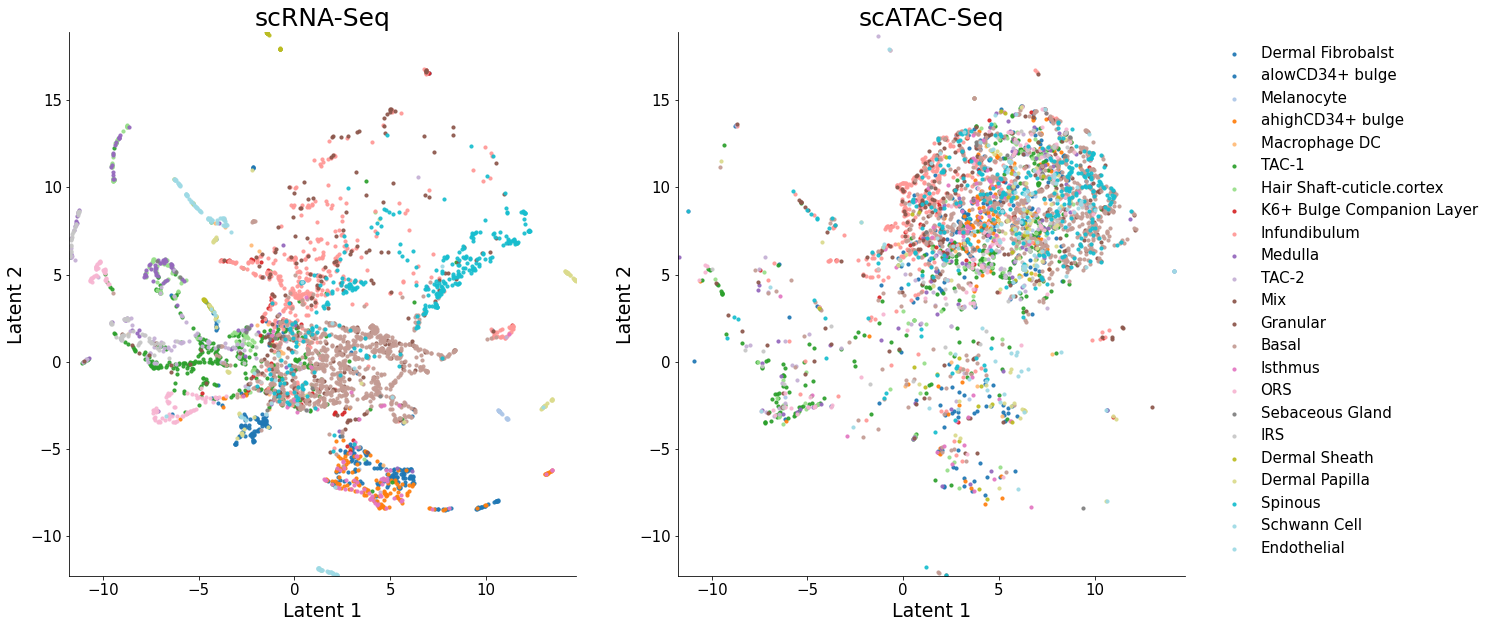

In [75]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 5, min_dist = 0.3) 

z_rna = model1.softmax(model1.C_1.cpu().detach())
z_atac = model1.softmax(model1.C_2.cpu().detach())
max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)

z_rna, z_atac = utils.match_alignment(z_rna, z_atac, k = 10)
z_atac, z_rna = utils.match_alignment(z_atac, z_rna, k = 10)


z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)["celltype"].values.squeeze()[::subsample]
label_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)["celltype"].values.squeeze()[::subsample]
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

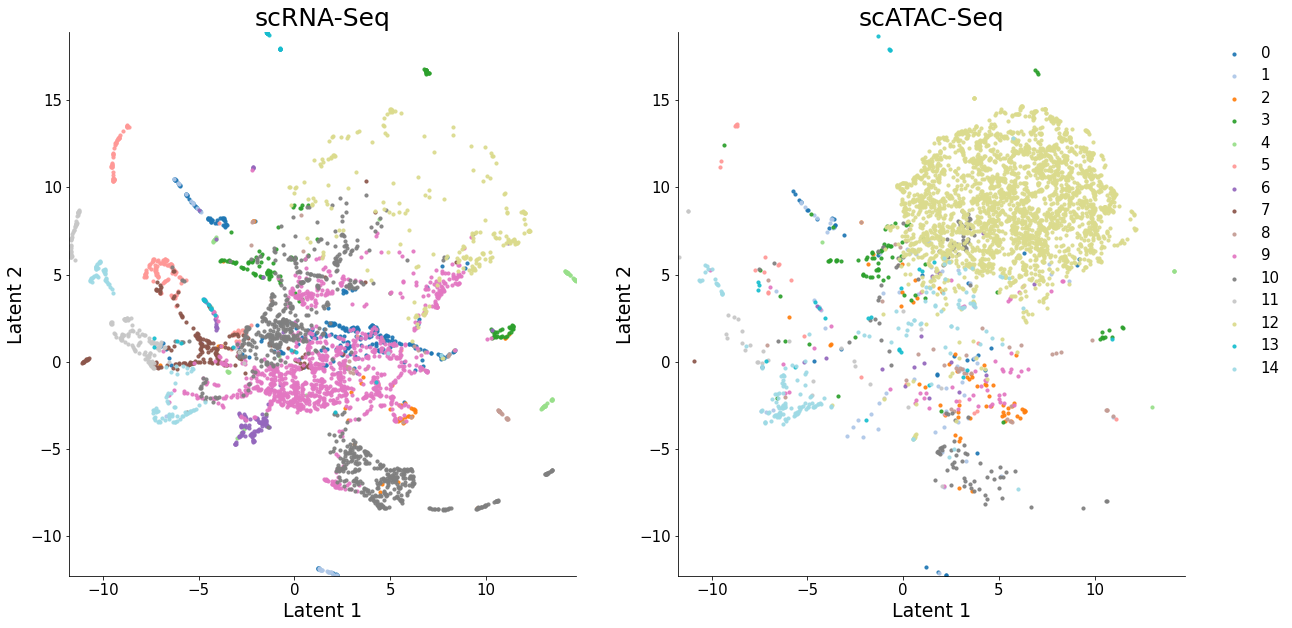

In [76]:
utils.plot_latent(z_rna, z_atac, max_rna, max_atac, mode= "separate", save = None)